An new environment was created called geopandas_env in which the geopandas package was installed through the following steps (based on https://medium.com/@sourav_raj/ultimate-easiest-way-to-install-geopandas-on-windows-add-to-jupyter-notebook-which-will-a4b11223f4f2):
- Open command shell from anaconda user interface
- Create environment by typing "conda create –n geopandas_env"
- Activate environment by typing "conda activate geopandas_env"
- conda config -- env -- add channels conda-forge
- conda config -- env -- set channel_priority strict
- conda install python=3 geopandas

Returning to the anaconda user interface, navigate to Environments and make sure descartes and wordcloud are included in the geopandas_env environment.

Launch Jupyter notebook while geopandas_env is activated.

In [20]:
import geopandas as gpd
import descartes
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from wordcloud import WordCloud

from matplotlib.gridspec import GridSpec

# See cleaningData.ipynb for data cleaning efforts 
data = pd.read_csv('cleanData.csv')

In [35]:
def wordCloudSurname(inputName,ax,longer):
    
    # Remove apostrophes and spaces
    name = inputName.replace("'", "").replace(" ", "").lower()
    
    # Remove spaces from the forename. This captures double names as a single name e.g. Mary Ann => MaryAnn
    file_text = data[data['Surname'] == name]['Forename'].str.replace(' ', '')
    # Make single string with each item in Forename column separated by space. 
    # Forename length must be > 2 in length
    text=" ".join(str(word) for word in file_text if len(str(word))>2)
    
    # collocations prevents wordcloud from trying to "tie" together frequent word combinations
    # normalize_plurals=True was giving "Jame" instead of "James"
    wordcloud = WordCloud(background_color ='whitesmoke',
                          width=1600,height=round(longer*1600),
                          min_font_size = 10,
                          collocations=False,
                          normalize_plurals=False,
                          max_words=50).generate(text)

    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_title('Most common '+inputName+' \nforenames\n',fontsize=26)
    ax.axis("off")
    return

In [275]:
# Counties shapefile is from Townlands.ie 
# Change Londonderry to Derry
counties = gpd.read_file('Mapping/counties.shp')
counties.at[11,'NAME_TAG'] = 'Derry'
counties['NAME_TAG'] = counties['NAME_TAG'].str.lower()

# These functions let us make a colormap with multiple colors that "hinges" around a chosen value
from matplotlib.colors import TwoSlopeNorm
from matplotlib.colors import Normalize

def makeNameMap(inputName,ax,mapType='absolute'):
    # inputName can be any surname
    # mapType can be one of 'absolute', 'percent', or 'factor'
    
    name = inputName.replace("'", "").replace(" ", "").lower()
        
    # Asbolute gives the population with the surname in each county
    if mapType == 'absolute':
        dfTemp = data[data['Surname'] == name]
        namePops = dfTemp['County'].value_counts()
        colorData = namePops
        
    # Percent gives the % of the population in that county that has that surname 
    if mapType == 'percent':
        dfTemp = data[data['Surname'] == name]
        namePops = dfTemp['County'].value_counts()
        pops = data['County'].value_counts()
        colorData = 100*namePops/pops
        
    # Factor gives the relative incidence of the surname in that county
    if mapType == 'factor':
        dfTemp = data[data['Surname'] == name]
        namePops = dfTemp['County'].value_counts()
        pops = data['County'].value_counts()
        totalPop = pops.sum()
        totalNamePop = namePops.sum()
        natIncidence = 100*totalNamePop/totalPop
        countyIncidence = 100*namePops/pops
        colorData = countyIncidence/natIncidence
    colorData = colorData.fillna(0)
    
    # Add the scalar values for absolute, percent or factor to the counties shapefile dataframe
    merged = counties.set_index('NAME_TAG').merge(colorData.rename('color'), left_index=True, right_index=True)
    
    vmin = colorData.min()
    vmax = colorData.max()
    
    if mapType == 'factor':
        # DivergingNorm allows the colors to change from red to blue around the first value i.e. 1
        sm = plt.cm.ScalarMappable(cmap='RdBu_r', norm=TwoSlopeNorm(1, vmin=0.1, vmax=vmax))
        merged.plot('color', cmap='RdBu_r', linewidth=0.8,ax=ax, edgecolor='black', figsize=(18,12),norm=TwoSlopeNorm(1))
        #ax.set_title(inputName+' surname incidence rate\n relative to national population', fontdict={'fontsize': '22', 'fontweight' : '15'})
    
    #ax.axis('off')
    sm._A = []
    cbar = plt.colorbar(sm,fraction=0.038, pad=0.00001)
    cbar.ax.tick_params(labelsize=20)
    ax.annotate(inputName+'s by county',
                xy=(0, 0.9), xycoords='axes fraction',
             xytext=(20, 20), textcoords='offset points',
             ha="left", va="bottom",fontsize=25)
    ax.annotate('A value of 2 means \nthat someone is \ntwice as likely to \nbe a '+inputName+' in \nthat county relative \nto the national \npopulation',
                xy=(0, 0.73), xycoords='axes fraction',
             xytext=(20, 20), textcoords='offset points',
             ha="left", va="bottom",fontsize=16)
    ax.axis('off')

    return

In [255]:
data.loc[(data['Religion'] == 'Other Protestants'),'Religion'] = 'Protestant'
data.loc[(data['Religion'] == 'Unspecified') |(data['Religion'] == 'Unspecified Christian') |\
         (data['Religion'] == 'World religion'),'Religion'] = 'Other'

def makeSurnameReligionBar(inputName,ax):
    name = inputName.replace("'", "").replace(" ", "").lower()
    
    import matplotlib.ticker as mticker

    series = data[data['Surname'] == name]['Religion'].value_counts()
    series = series.sort_values(ascending=[True])
    series.plot.barh(width=0.6)

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    ax.tick_params(axis='y',length=0,labelsize=18)
    ax.tick_params(axis='x',which='major',length=10,width=1,labelsize=18)
    ax.tick_params(axis='x',which='minor',length=5,width=1,labelsize=18)
    ax.set_xscale('log')
    ax.xaxis.set_major_formatter(mticker.ScalarFormatter())
    ax.xaxis.get_major_formatter().set_scientific(False)
    ax.set_xlim(series.min() - 0.5*series.min(),series.max()+8*series.max())
    perList = series/series.sum()

    for p,per in zip(ax.patches,perList):
        width = p.get_width()
        height = p.get_height()
        x, y = p.get_xy()
        ax.annotate(str("{:.1f}".format(100*per))+'%', (x + width, y + height*0.25), 
                    ha='left',fontsize=15)

In [39]:
def makeLiteracyPie(inputName,ax):
    
    name = inputName.replace("'", "").replace(" ", "").lower()
    vals = data[data['Surname'] == name]['Literacy'].value_counts()[0:3]
    
    total = data['Literacy'][data['Surname'] == name].value_counts().sum()
    literate = data['Literacy'][data['Surname'] == name].value_counts()['Literate']/total
    illiterate = data['Literacy'][data['Surname'] == name].value_counts()['Illiterate']/total
    onlyRead = data['Literacy'][data['Surname'] == name].value_counts()['Can only read']/total
    
    vals.plot.pie(autopct='%1.f%%',textprops={'fontsize': 16},startangle=90,
                  wedgeprops={"edgecolor":"w",'linewidth': 1, 'antialiased': True})
    ax.axis('off')

In [218]:
def makeSurnameAgeHistF(inputName,ax):
    name = inputName.replace("'", "").replace(" ", "").lower()

    data[data['Sex'] == 'f'][data['Surname'] == name]['Age'].plot.hist(bins=np.arange(0,105,5),
                                              color='pink',
                                              orientation='horizontal',
                                              sharey=True,
                                              fontsize=14,
                                              edgecolor="black")
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)
    ax.invert_xaxis()
    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()
    ax.set(xlabel=None)
    ax.tick_params(axis='both',labelsize=16,width=2)
    ax.yaxis.set_ticks(np.arange(0, 110, 10))
    ax.set_xlabel('Population',fontsize=16)
    ax.annotate('Age \ndistribution \nof '+inputName+' \nwomen',
             xy=(0.1, 0.5), xycoords='axes fraction',
             xytext=(20, 20), textcoords='offset points',
             ha="left", va="bottom",fontsize=20)
    
def makeSurnameAgeHistM(inputName,ax):
    name = inputName.replace("'", "").replace(" ", "").lower()
    data[data['Sex'] == 'm'][data['Surname'] == name]['Age'].plot.hist(bins=np.arange(0,105,5),
                                              color='lightskyblue',
                                              orientation='horizontal',
                                              fontsize=14,
                                              edgecolor="black")
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)
    ax.set(xlabel=None)
    ax.tick_params(axis='both',labelsize=16,width=2)
    ax.yaxis.set_ticks(np.arange(0, 110, 10))
    ax.set(yticklabels=[])
    ax.set_xlabel('Population',fontsize=16)
    ax.annotate('Age \ndistribution \nof '+inputName+' \nmen',
                xy=(0.5, 0.5), xycoords='axes fraction',
             xytext=(20, 20), textcoords='offset points',
             ha="left", va="bottom",fontsize=20)

In [197]:
def makeLiteracyNameText(inputName,ax):
    name = inputName.replace("'", "").replace(" ", "").lower()
    
    irishTotal = data['Irish Language'][data['Surname'] == name].value_counts().sum()
    irishSecond = data['Irish Language'][data['Surname'] == name].value_counts()['English & Irish']/irishTotal
    total = data['Literacy'][data['Surname'] == name].value_counts().sum()
    
    neverMoved = data[data['Surname'] == name]['Movement'].value_counts()['Live in   \ncounty they \nwere born in']
    moved = data[data['Surname'] == name]['Movement'].value_counts().sum()

    ax.annotate(str("{:,}".format(total)),
                    xy=(0, 1), xycoords='axes fraction',
                 xytext=(20, 20), textcoords='offset points',
                 ha="left", va="bottom",fontsize=40)
    ax.annotate('total '+inputName+'s',
                    xy=(0, 0.92), xycoords='axes fraction',
                 xytext=(20, 20), textcoords='offset points',
                 ha="left", va="bottom",fontsize=25)
    
    ax.annotate(str(round(100*neverMoved/moved))+'%',
                    xy=(0, 0.77), xycoords='axes fraction',
                 xytext=(20, 20), textcoords='offset points',
                 ha="left", va="bottom",fontsize=40)
    ax.annotate('never moved county',
                    xy=(0, 0.7), xycoords='axes fraction',
                 xytext=(20, 20), textcoords='offset points',
                 ha="left", va="bottom",fontsize=25)
    
    ax.annotate(str(round(100*irishSecond))+'%',
                    xy=(0, 0.54), xycoords='axes fraction',
                 xytext=(20, 20), textcoords='offset points',
                     ha="left", va="bottom",fontsize=40)
    ax.annotate('claim Irish as a \nsecond language',
                    xy=(0, 0.4), xycoords='axes fraction',
                 xytext=(20, 20), textcoords='offset points',
                 ha="left", va="bottom",fontsize=25)
    
    ax.annotate(str(np.round(data[data['Sex'] == 'f'][data['Surname'] == name]['Children Born'].dropna().mean(),1)),
                    xy=(0, 0.25), xycoords='axes fraction',
                 xytext=(20, 20), textcoords='offset points',
                     ha="left", va="bottom",fontsize=40)
    ax.annotate('fertility rate in\n'+inputName+' women',
                    xy=(0, 0.1), xycoords='axes fraction',
                 xytext=(20, 20), textcoords='offset points',
                 ha="left", va="bottom",fontsize=25)

    ax.axis('off')

In [198]:
def occupationList(inputName,ax,num):
    name = inputName.replace("'", "").replace(" ", "").lower()
    occValue = data[data['Surname'] == name][data['Age'] > 16]['Occupation'].value_counts().values[num]
    occLabel = data[data['Surname'] == name][data['Age'] > 16]['Occupation'].value_counts().index[num]
    
    "{:,}".format(occValue)
    ax.annotate(str(round(num+1))+'. '+occLabel+' ('+str("{:,}".format(occValue))+')',
             xy=(0, 0.25), xycoords='axes fraction',
             xytext=(0, 0), textcoords='offset points',
             ha="left", va="bottom",fontsize=18)
    ax.axis('off')

In [268]:
def makeInfographic(inputName,saveFig=False):
    name = inputName.replace("'", "").replace(" ", "").lower()
    
    if name in data.values:
        fig = plt.figure(figsize=(15,20),edgecolor='k',facecolor='whitesmoke')
        
        plt.suptitle(inputName+'s in 1911\n\n\n\n',fontsize=50)

        gs1 = GridSpec(1, 1, left=0, right=0.55,top=1,bottom=0.4)
        ax1 = fig.add_subplot(gs1[:, :],facecolor="none")
        makeNameMap(inputName,ax1,mapType = 'factor')

        gs2 = GridSpec(1, 1, left=0.65, right=1,top=0.88,bottom=0.5)
        ax2 = fig.add_subplot(gs2[:, :],facecolor="none")
        wordCloudSurname(inputName,ax=ax2,longer=1.4)

        gs3 = GridSpec(1, 1, left=0.11, right=0.43,top=0.45,bottom=0.25)
        ax3 = fig.add_subplot(gs3[:, :],facecolor="none")
        makeSurnameReligionBar(inputName,ax3)

        gs4 = GridSpec(1, 1, left=0.76, right=1,top=0.45,bottom=0.25)
        ax4 = fig.add_subplot(gs4[:, :],facecolor="none")
        makeLiteracyPie(inputName,ax4)

        gs5 = GridSpec(1, 1, left=0.45, right=0.78,top=0.45,bottom=0.2)
        ax5 = fig.add_subplot(gs5[:, :],facecolor="none")
        makeLiteracyNameText(inputName,ax5)

        gs6 = GridSpec(1, 2, left=0.25, right=1,top=0.22,bottom=0,wspace=0.1)
        ax6a = fig.add_subplot(gs6[0,0],facecolor="none")
        makeSurnameAgeHistF(inputName,ax6a)
        ax6b = fig.add_subplot(gs6[0,1],facecolor="none")
        makeSurnameAgeHistM(inputName,ax6b)
        
        gs7 = GridSpec(6, 1, left=0.02, right=0.2,top=0.2,bottom=0.07,hspace=0)
        ax7a = fig.add_subplot(gs7[0,0],facecolor="none")
        plt.annotate('Reported occupations\n(older than 16)',
             xy=(0, 0), xycoords='axes fraction',
             xytext=(0, 0), textcoords='offset points',
             ha="left", va="bottom",fontsize=20)
        plt.axis('off')
        ax7b = fig.add_subplot(gs7[1,0],facecolor="none")
        occupationList(inputName,ax7b,0)
        ax7c = fig.add_subplot(gs7[2,0],facecolor="none")
        occupationList(inputName,ax7c,1)
        ax7d = fig.add_subplot(gs7[3,0],facecolor="none")
        occupationList(inputName,ax7d,2)
        ax7e = fig.add_subplot(gs7[4,0],facecolor="none")
        occupationList(inputName,ax7e,3)
        ax7f = fig.add_subplot(gs7[5,0],facecolor="none")
        occupationList(inputName,ax7f,4)

        
        if saveFig:
            fig.savefig(inputName)
        
    else:
        plt.figure()
        plt.annotate('Nothing found.\n'+inputName+' is clearly \nnot an Irish name!',
                 xy=(0, 0), xycoords='axes fraction',
                 xytext=(20, 20), textcoords='offset points',
                 ha="left", va="bottom",fontsize=100)

        plt.axis('off')

<ipython-input-197-e52922e4efae>:38: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ax.annotate(str(np.round(data[data['Sex'] == 'f'][data['Surname'] == name]['Children Born'].dropna().mean(),1)),
<ipython-input-218-b227b7cdfe68>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data[data['Sex'] == 'f'][data['Surname'] == name]['Age'].plot.hist(bins=np.arange(0,105,5),
<ipython-input-218-b227b7cdfe68>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data[data['Sex'] == 'm'][data['Surname'] == name]['Age'].plot.hist(bins=np.arange(0,105,5),
<ipython-input-198-7912f2d0b036>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  occValue = data[data['Surname'] == name][data['Age'] > 16]['Occupation'].value_counts().values[num]
<ipython-input-198-7912f2d0b036>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  occLabel = data[data['Surname']

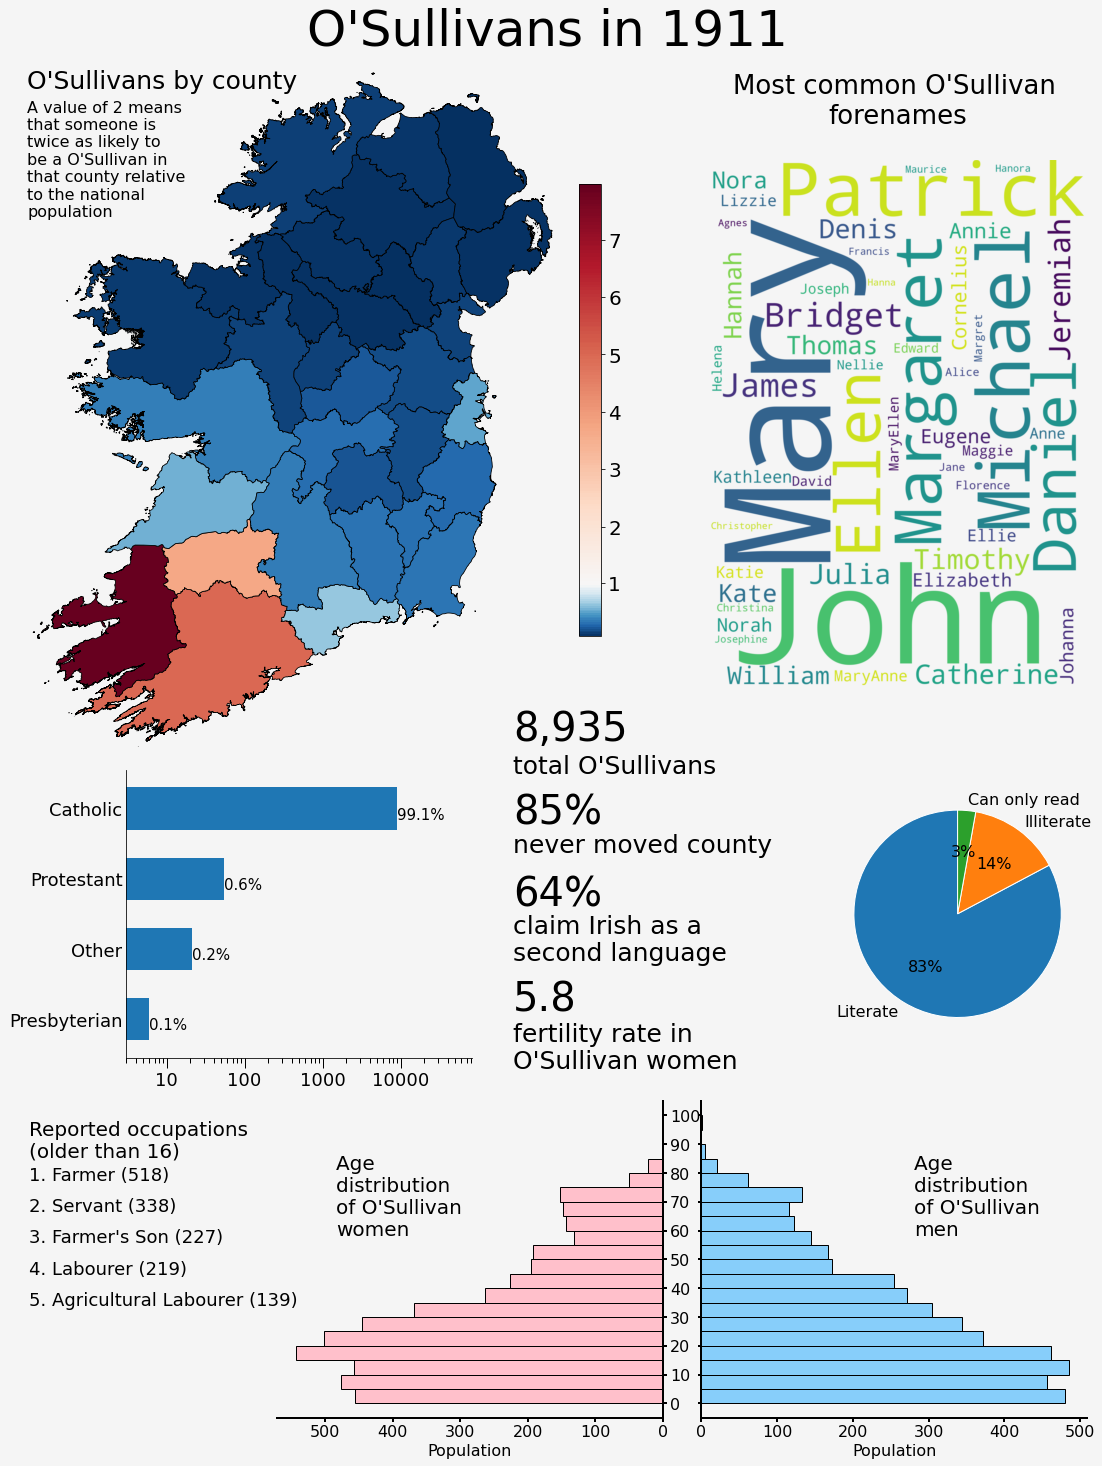

In [270]:
makeInfographic('O\'Sullivan',saveFig=True)

<ipython-input-197-e52922e4efae>:38: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ax.annotate(str(np.round(data[data['Sex'] == 'f'][data['Surname'] == name]['Children Born'].dropna().mean(),1)),
<ipython-input-218-b227b7cdfe68>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data[data['Sex'] == 'f'][data['Surname'] == name]['Age'].plot.hist(bins=np.arange(0,105,5),
<ipython-input-218-b227b7cdfe68>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data[data['Sex'] == 'm'][data['Surname'] == name]['Age'].plot.hist(bins=np.arange(0,105,5),
<ipython-input-198-7912f2d0b036>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  occValue = data[data['Surname'] == name][data['Age'] > 16]['Occupation'].value_counts().values[num]
<ipython-input-198-7912f2d0b036>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  occLabel = data[data['Surname']

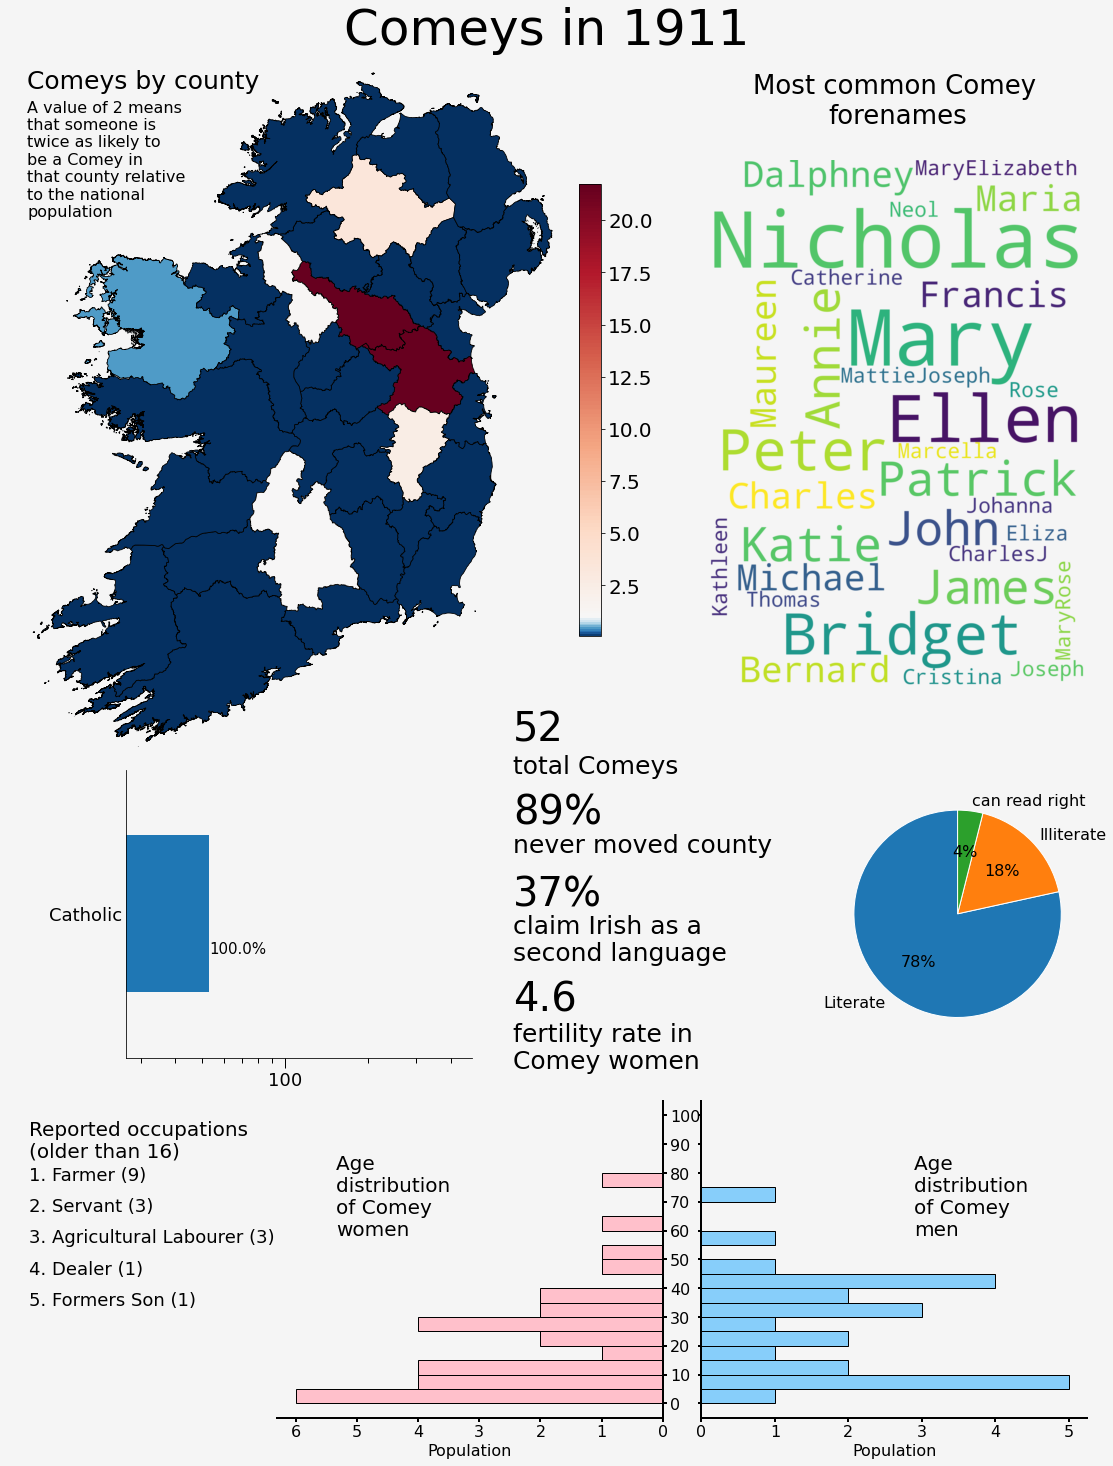

In [271]:
makeInfographic('Comey',saveFig=True)

<ipython-input-197-e52922e4efae>:38: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ax.annotate(str(np.round(data[data['Sex'] == 'f'][data['Surname'] == name]['Children Born'].dropna().mean(),1)),
<ipython-input-218-b227b7cdfe68>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data[data['Sex'] == 'f'][data['Surname'] == name]['Age'].plot.hist(bins=np.arange(0,105,5),
<ipython-input-218-b227b7cdfe68>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data[data['Sex'] == 'm'][data['Surname'] == name]['Age'].plot.hist(bins=np.arange(0,105,5),
<ipython-input-198-7912f2d0b036>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  occValue = data[data['Surname'] == name][data['Age'] > 16]['Occupation'].value_counts().values[num]
<ipython-input-198-7912f2d0b036>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  occLabel = data[data['Surname']

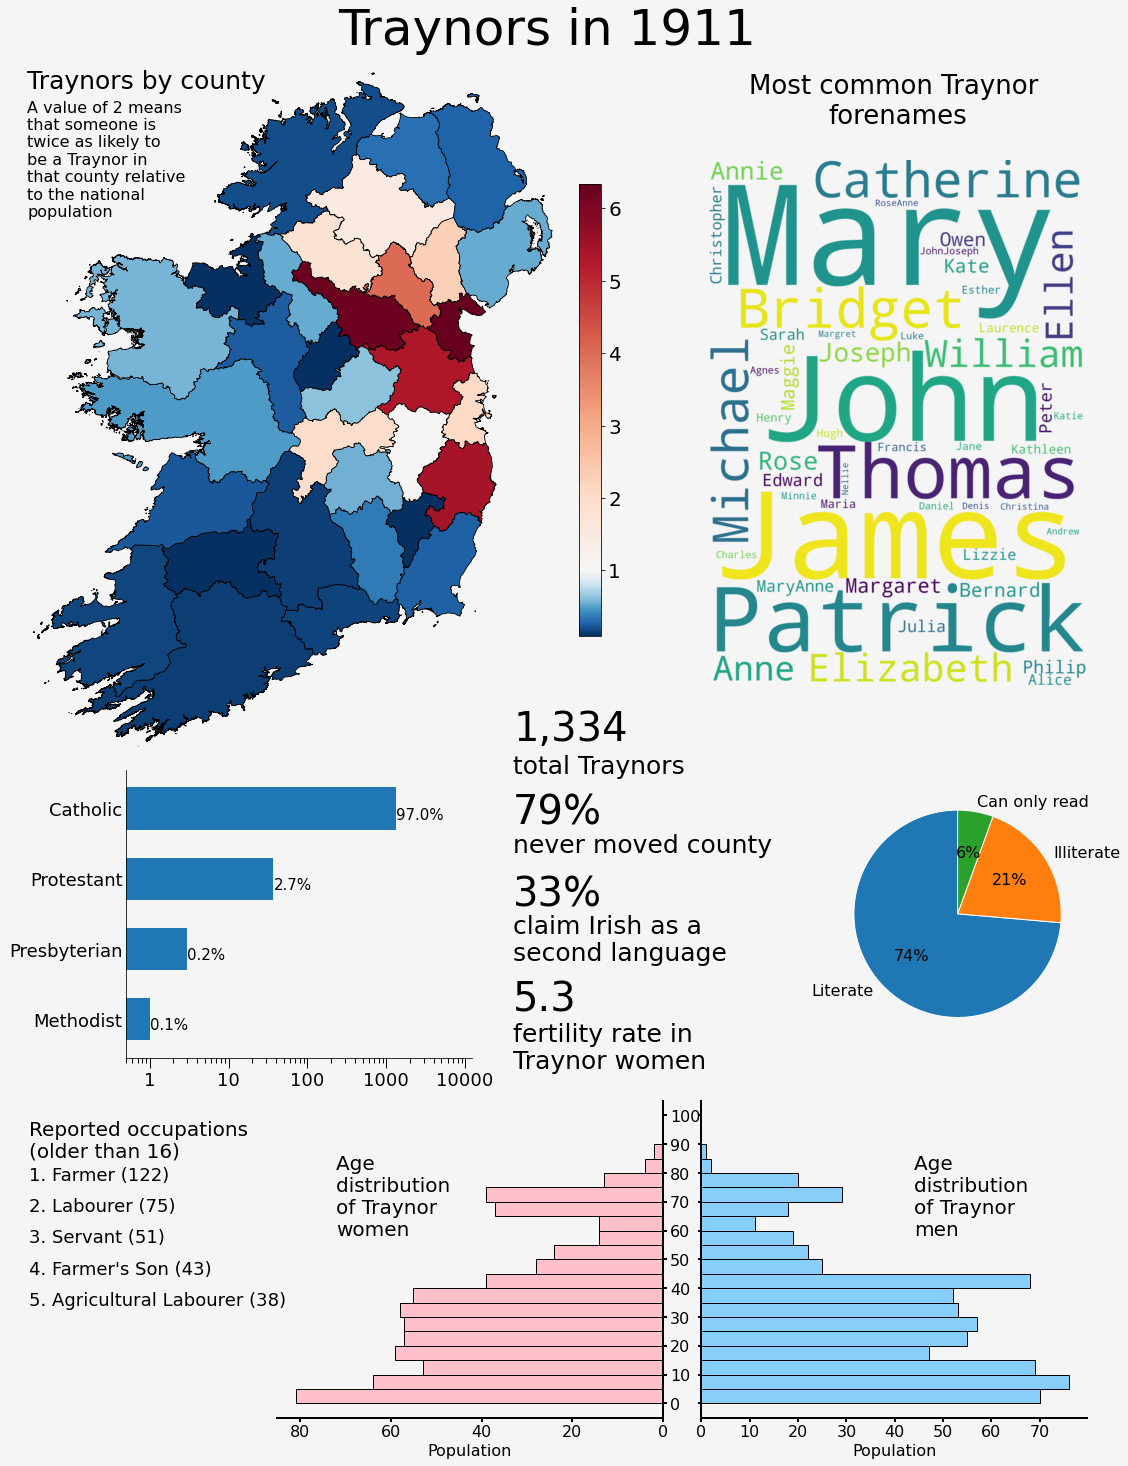

In [272]:
makeInfographic('Traynor',saveFig=True)

<ipython-input-197-e52922e4efae>:38: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ax.annotate(str(np.round(data[data['Sex'] == 'f'][data['Surname'] == name]['Children Born'].dropna().mean(),1)),
<ipython-input-218-b227b7cdfe68>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data[data['Sex'] == 'f'][data['Surname'] == name]['Age'].plot.hist(bins=np.arange(0,105,5),
<ipython-input-218-b227b7cdfe68>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data[data['Sex'] == 'm'][data['Surname'] == name]['Age'].plot.hist(bins=np.arange(0,105,5),
<ipython-input-198-7912f2d0b036>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  occValue = data[data['Surname'] == name][data['Age'] > 16]['Occupation'].value_counts().values[num]
<ipython-input-198-7912f2d0b036>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  occLabel = data[data['Surname']

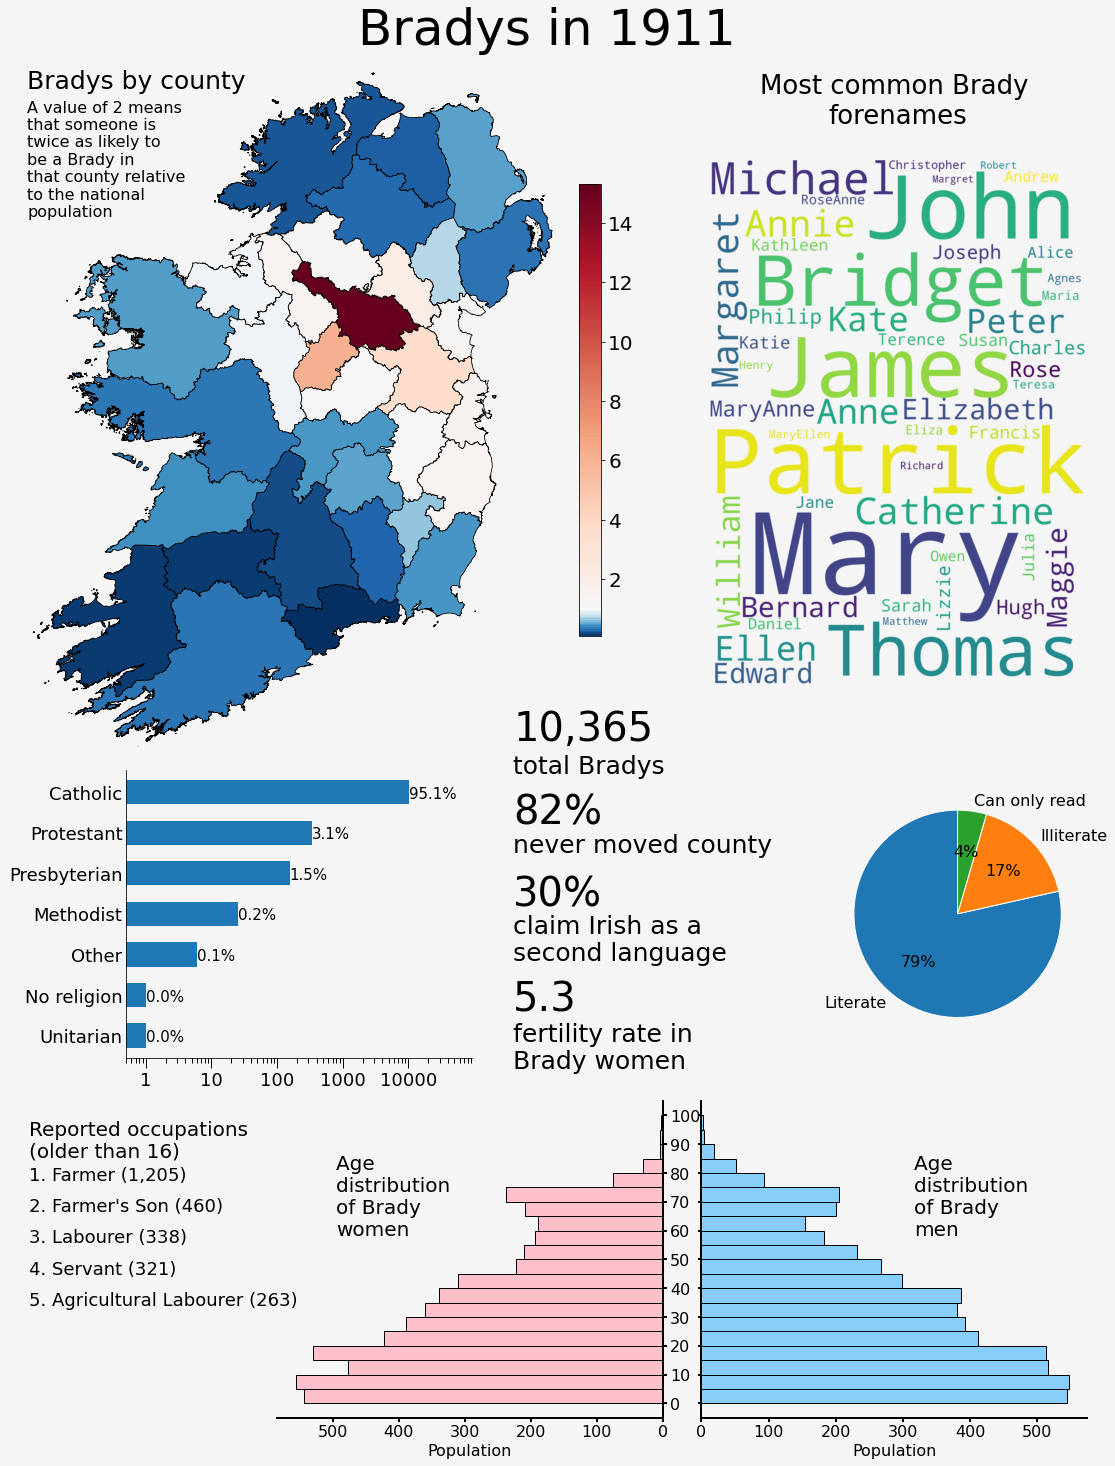

In [273]:
makeInfographic('Brady',saveFig=True)

<ipython-input-197-e52922e4efae>:38: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ax.annotate(str(np.round(data[data['Sex'] == 'f'][data['Surname'] == name]['Children Born'].dropna().mean(),1)),
<ipython-input-218-b227b7cdfe68>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data[data['Sex'] == 'f'][data['Surname'] == name]['Age'].plot.hist(bins=np.arange(0,105,5),
<ipython-input-218-b227b7cdfe68>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data[data['Sex'] == 'm'][data['Surname'] == name]['Age'].plot.hist(bins=np.arange(0,105,5),
<ipython-input-198-7912f2d0b036>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  occValue = data[data['Surname'] == name][data['Age'] > 16]['Occupation'].value_counts().values[num]
<ipython-input-198-7912f2d0b036>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  occLabel = data[data['Surname']

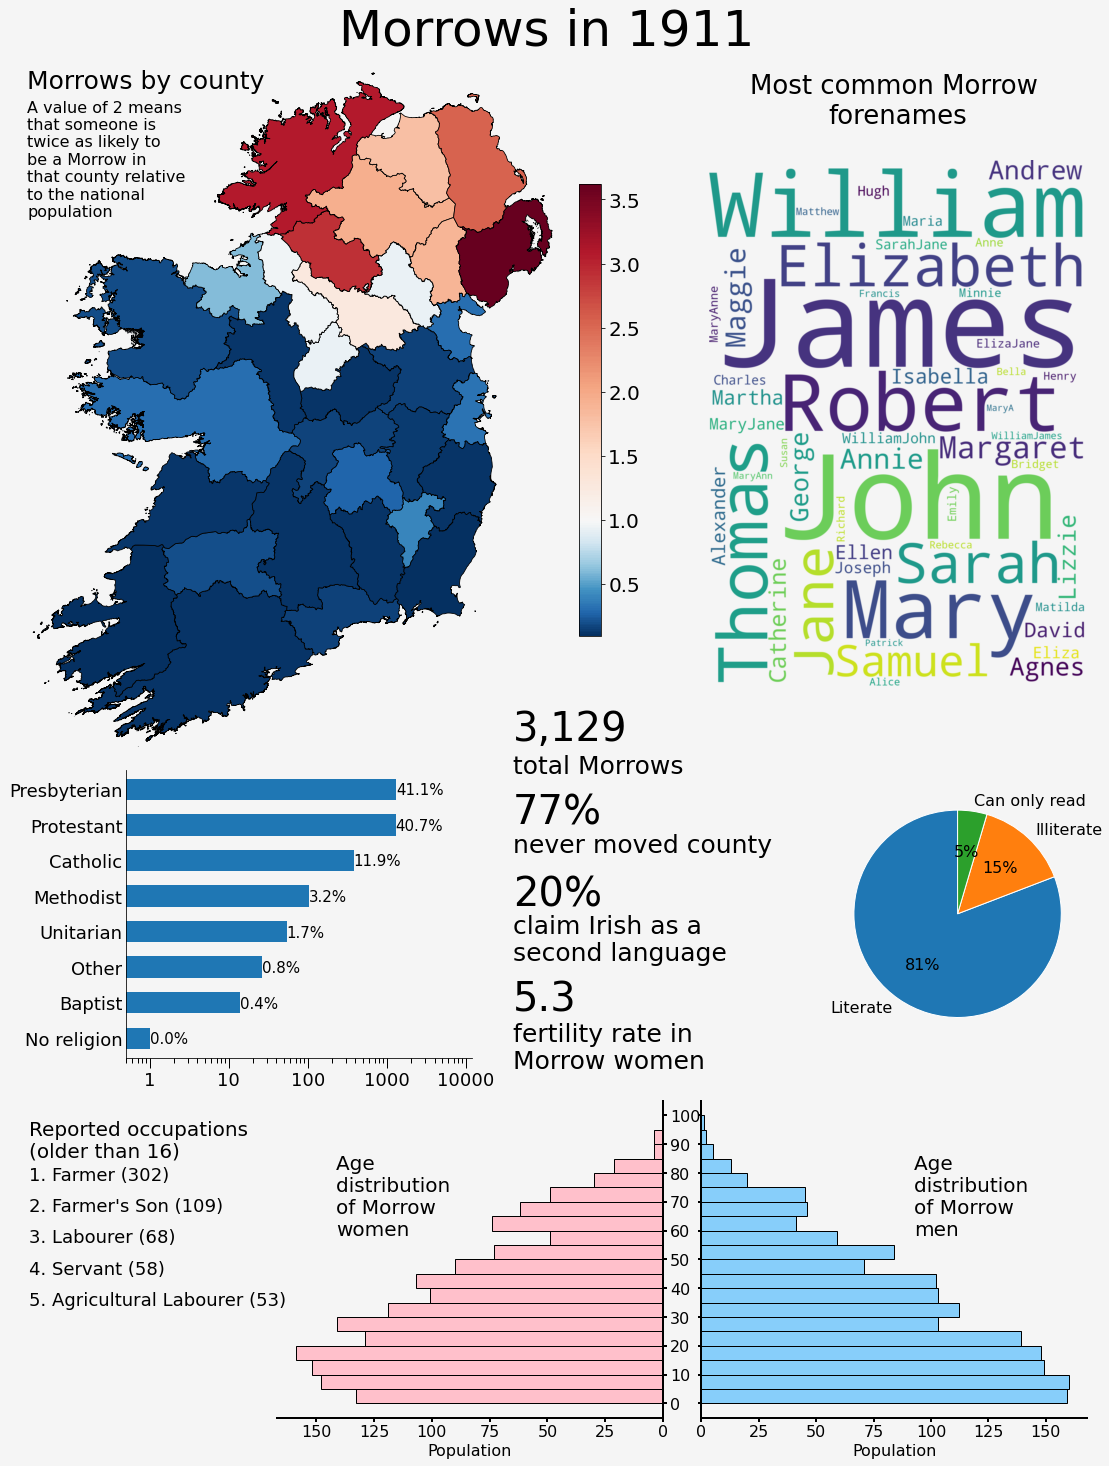

In [274]:
makeInfographic('Morrow',saveFig=True)